In [ ]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
r=urlopen('http://files.grouplens.org/datasets/movielens/ml-1m.zip')
zipfile = ZipFile(BytesIO(r.read()))
zipfile.namelist()

['ml-1m/',
 'ml-1m/movies.dat',
 'ml-1m/ratings.dat',
 'ml-1m/README',
 'ml-1m/users.dat']

In [ ]:
import pandas as pd
import numpy as np
rating_cols=['user_id','movie_id','rating','unix_timestamp']
ratings_df = pd.read_csv(zipfile.open('ml-1m/ratings.dat'),sep='::',names=rating_cols)
ratings_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


,user_id,movie_id,rating,unix_timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [ ]:
ratings_df.shape

(1000209, 4)

In [ ]:
movie_cols = ['movie_id', 'title', 'genre']
movies_df = pd.read_csv(zipfile.open('ml-1m/movies.dat'),sep='::',names=movie_cols,usecols=range(5),encoding='latin-1')
movies_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
movies_df.shape

(3883, 3)

In [ ]:
!pip install surprise

     |████████████████████████████████| 11.8MB 5.5MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670908 sha256=9d7955e507f6bc07f964ff2b3c2a7090f741bf2f71d1003acf55f1b0c655f62d
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
from surprise.reader import Reader
from surprise import Dataset
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from surprise import NMF
reader=Reader(rating_scale=(0,5))
data=Dataset.load_from_df(ratings_df[["user_id","movie_id","rating"]],reader=reader)
trainset=data.build_full_trainset()

In [ ]:
def factors(alg,data):
  rmse=[]
  for i in range(0,51):
    algo=alg(n_factors=i)
    err=cross_validate(algo,data,measures=['RMSE'],cv=5,verbose=False)["test_rmse"].mean()
    rmse.append(err)
  return rmse

In [ ]:
rmse_nmf=factors(NMF,data)

In [ ]:
def plot_rmse(rmse,alg):
  plt.figure(num=None,figsize=(10,5),facecolor='w',edgecolor='k')
  plt.title("{0} Performance: Factors vs RMSE".format(alg),size=20)
  plt.plot(rmse)
  plt.xlim(0,50)
  plt.xticks(np.arange(0,52,step=2))
  plt.xlabel("{0}(n_factor = k)".format(alg))
  plt.ylabel("Mean RMSE (cv=5)")
  plt.axvline(np.argmin(rmse),color ="r")

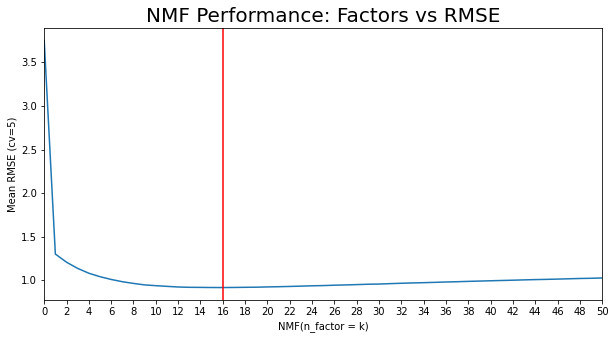

In [ ]:
import matplotlib.pyplot as plt
plot_rmse(rmse_nmf,"NMF")

In [ ]:
param_grid={'n_factors':[10,12,14,16,18]}
gs=GridSearchCV(NMF, param_grid, measures=['rmse'], cv=5)
gs.fit(data)
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.9168188091987659
{'n_factors': 14}


In [ ]:
nmfmodel=NMF(n_factors=14)
nmfmodel.fit(trainset)
testset=trainset.build_anti_testset()
predictions=nmfmodel.test(testset)
predictions[0:5]

[Prediction(uid=1, iid=1357, r_ui=3.581564453029317, est=4.3359210152818894, details={'was_impossible': False}),
 Prediction(uid=1, iid=3068, r_ui=3.581564453029317, est=4.136711196250731, details={'was_impossible': False}),
 Prediction(uid=1, iid=1537, r_ui=3.581564453029317, est=4.234129565790436, details={'was_impossible': False}),
 Prediction(uid=1, iid=647, r_ui=3.581564453029317, est=3.5765454480385817, details={'was_impossible': False}),
 Prediction(uid=1, iid=2194, r_ui=3.581564453029317, est=4.228722294468294, details={'was_impossible': False})]

In [ ]:
from collections import defaultdict
def top_n_movies(predictions,user_id,movies,ratings,n=3):
    top_n=defaultdict(list)
    for uid,iid,true_r,est,_ in predictions:
        top_n[uid].append((iid,est))

    for uid,user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1],reverse=True)
        top_n[uid]=user_ratings[:n]

    user_data=ratings[ratings.user_id==(user_id)]
    print('User {0} has rated {1} movies'.format(user_id,user_data.shape[0]))
    preds=pd.DataFrame([(id, pair[0],pair[1]) for id,row in top_n.items() for pair in row],columns=["user_id" ,"movie_id","predicted_rating"])
    user_predictions=preds[preds["user_id"]==(user_id)].merge(movies,how='left',left_on='movie_id',right_on='movie_id')

    user_history=ratings[ratings.user_id==(user_id) ].sort_values("rating",ascending=False).merge(movies,how ='left',left_on ='movie_id',right_on ='movie_id')
    return user_history,user_predictions

In [ ]:
uid=int(input())
n=int(input())
user_history,user_predictions=top_n_movies(predictions,uid,movies_df,ratings_df,n)

25
5
User 25 has rated 85 movies


In [ ]:
user_history.head()

,user_id,movie_id,rating,unix_timestamp,title,genre
0,25,1270,5,978132138,Back to the Future (1985),Comedy|Sci-Fi
1,25,2011,5,978132424,Back to the Future Part II (1989),Comedy|Sci-Fi
2,25,1291,5,978132431,Indiana Jones and the Last Crusade (1989),Action|Adventure
3,25,1610,5,978132793,"Hunt for Red October, The (1990)",Action|Thriller
4,25,2501,5,978132742,October Sky (1999),Drama


In [ ]:
user_predictions

,user_id,movie_id,predicted_rating,title,genre
0,25,3245,5.0,I Am Cuba (Soy Cuba/Ya Kuba) (1964),Drama
1,25,53,5.0,Lamerica (1994),Drama
2,25,557,5.0,Mamma Roma (1962),Drama
3,25,989,5.0,Schlafes Bruder (Brother of Sleep) (1995),Drama
4,25,572,5.0,Foreign Student (1994),Drama
